In [4]:
from pydantic import BaseModel
from typing import List, Optional
from langgraph.graph import StateGraph, END, MessagesState
from typing import Annotated
from langgraph.graph import add_messages, StateGraph, END

In [5]:
from dotenv import load_dotenv
import os
load_dotenv()

True

In [6]:
from pydantic import BaseModel
from typing import List, Annotated,Dict
from langgraph.graph import add_messages
from langgraph.graph import StateGraph, END, MessagesState

class SupervisorState(MessagesState):
    """State for the multi-agent system"""
    messages: Annotated[List, add_messages]
    image_path: str = ""
    history: List[Dict[str, str]] = []
    user_query: str = ""
    next_agent: str = ""    
    Images_data: str = ""
    scientific_data: str = ""
    products_data: str = ""
    final_answer: str = ""
    task_complete: bool = False
    current_task: str = ""
    task_related_to_haircare: bool = True

In [7]:
from pydantic import BaseModel
from typing import List, Optional
from langgraph.graph import StateGraph, END, MessagesState
from typing import Annotated
from langgraph.graph import add_messages, StateGraph, END
from langchain_core.messages import AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from google import genai
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
#llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0.5)

from dotenv import load_dotenv
import os
load_dotenv()
embedding_function = OpenAIEmbeddings(model="text-embedding-3-large")

llm = ChatOpenAI(model_name="gpt-4o", temperature=0.5)
#llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", api_key=os.getenv("GOOGLE_API_KEY"))
new_db = FAISS.load_local("hair_care_faiss_index", embedding_function, allow_dangerous_deserialization=True)
new_retriever = new_db.as_retriever(search_type="mmr", search_kwargs={"k": 3})


def create_supervisor_chain():
    supervisor_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a supervisor managing a team of agents:
        
        1. image_analyzer - analyzes an input image
        2. scientific_researcher - retrieves scientific data
        3. prodcuts_expert - provides haircare product info

        Decide which agent should work next based on progress.
        If everything is complete, respond with 'DONE'.

        Current state:
        - Has image data: {has_image}
        - Has scientific data: {has_scientific}
        - Has product info: {has_product_info}
        - Has final answer: {has_final_answer}
        - task_related_to_haircare: {task_related_to_haircare}
        
       
        Respond ONLY with one of:
        image_analyzer / scientific_researcher / prodcuts_expert / DONE

        """),
        ("human", "{task}")
    ])
    return supervisor_prompt | llm


def supervisor_agent(state):
    messages = state["messages"]
    task = messages[-1].content if messages else "No task"
    has_image = bool(state.get("Images_data"))
    has_scientific = bool(state.get("scientific_data"))
    has_product_info = bool(state.get("products_data"))
    has_final_answer = bool(state.get("final_answer"))




    chain = create_supervisor_chain()
    decision = chain.invoke({
        "task": task,
        "has_image": has_image,
        "has_scientific": has_scientific,
        "has_product_info": has_product_info,
        "has_final_answer": has_final_answer,
        "task_related_to_haircare": state.get("task_related_to_haircare")
    })

    decision_text = decision.content.strip().lower()
    print("🧠 Supervisor Decision:", decision_text)

    if state.get("task_related_to_haircare") == False:
        next_agent = "final_answer_agent"
        return {
            "next_agent": next_agent,
            "current_task": task
        }
    

    if "done" in decision_text or has_final_answer:
        next_agent = "final_answer_agent"
        supervisor_msg = "✅ Supervisor: All tasks complete! Great work team."
    elif "image_analyzer" in decision_text or not has_image:
        next_agent = "image_analysis_agent"
        supervisor_msg = "📋 Supervisor: Let's start with the image analysis..."
    elif "scientific_researcher" in decision_text or (has_image and not has_scientific):
        next_agent = "scientific_data_agent"
        supervisor_msg = "📋 Supervisor: Image analyzed. Moving to scientific research..."
    elif "prodcuts_expert" in decision_text or (has_scientific and not has_product_info):
        next_agent = "products_data_agent"
        supervisor_msg = "📋 Supervisor: Scientific research complete. Assigning to product expert..."
    else:
        next_agent = "final_answer_agent"
        supervisor_msg = "✅ Supervisor: Proceeding to final report."

    return {
        "messages": [AIMessage(content=supervisor_msg)],
        "next_agent": next_agent,
        "current_task": task
    }

def image_analysis_agent(state):
    image_path = state.get("image_path", "")
    client = genai.Client()
    my_file = client.files.upload(file=image_path)
    response = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=[
            my_file,
            "You are an expert in hair care. Analyze the provided image and describe the hair type.\n\nPossible hair types are:\n- Heavily Damaged & Dry\n- Colored & Bleached\n- Heavily Damaged\n- Damaged & Dry\n- Dry, Damaged\n- Dry & Colored\n- Damaged & Bleached\n- Strawy, Damaged\n- Brittle & Dull\n- Prone to Split Ends\n- Normal to Dry\n- Fine & Slightly Dry\n- Normal & Fine\n- Long hair with greasy roots\n- Long hair, fine & normal\n- Long hair with dry tips\n\nProvide a brief description of the hair type and any additional observations."
        ]
    )
    state["Images_data"] = response.text
    agent_message = f"🖼️ Image Analysis Agent: I've analyzed the image.\n\nHair Type: {response.text}"
    return {
        "messages": [AIMessage(content=agent_message)],
        "Images_data": response.text,
        "next_agent": "supervisor"
    }

def scientific_data_agent(state):
    task = state.get("current_task", "scientific query")
    query_prompt = f"""As a scientific data specialist, retrieve the most relevant information about: {task}\n\n
    Include:\n
    1. Key scientific findings\n
    2. Relevant studies or research\n
    3. Important data points\n
    4. Practical applications\n\n
    Be concise but thorough."""
    query = state.get("messages", [HumanMessage(content="")])[-1].content
    results = new_retriever.invoke(query, k=3)
    documents = "\n\n".join([doc.page_content for doc in results])
    agent_message = f"🔍 Scientific Data Agent: I've retrieved the most relevant data for '{task}'.\n\nKey findings:\n{documents[:500]}..."
    return {
        "messages": [AIMessage(content=agent_message)],
        "scientific_data": documents,
        "next_agent": "supervisor"
    }

def task_classifier_agent(state):

    task = state.get("messages", [HumanMessage(content="")])[-1].content

    classification_prompt = f"""
    Classify the following task: {task}

    Is this task related to hair? Answer 'yes' or 'no'.
    """

    classification = llm.invoke(classification_prompt)

    answer = classification.content.strip().lower()
    is_hair_care_task = "yes" in answer  # <-- FIXED

    state["task_related_to_haircare"] = is_hair_care_task

    return {
        "task_related_to_haircare": is_hair_care_task,
        "next_agent": "supervisor"
    }




def products_data_agent(state):
    products_data = """
    Gliss Haircare – Verified Detailed Overview
    This document combines verified data from Schwarzkopf/Gliss official sources with supplementary
    insights about ingredient benefits. Verified information is based on official product descriptions;
    supplementary details are derived from general cosmetic ingredient knowledge.

    Gliss Ultimate Repair
    Verified Information (from Schwarzkopf/Gliss):
    - Key Ingredients: Black Pearl, Liquid Keratin
    - Effect: Deep reconstruction of very damaged hair, replaces lost keratin, improves resistance and shine.
    - Suitable For: Extremely damaged or dry hair needing intense repair.
    Supplementary Details (based on ingredient properties):
    - Benefits from Ingredients: Enhances elasticity, repairs damage, promotes healthy shine, fortifies cell structure.
    - Fragrance: Sensual Rich
    - Care Level: Deep / Intensive

    Gliss Total Repair
    Verified Information (from Schwarzkopf/Gliss):
    - Key Ingredients: Floral Nectar, Hydrolyzed Keratin
    - Effect: Nourishes and smooths hair, reduces breakage, improves manageability.
    - Suitable For: Dry, stressed, or dull hair.
    Supplementary Details (based on ingredient properties):
    - Benefits from Ingredients: Seals moisture, supports follicle nutrition, restores sebaceous secretion balance.
    - Fragrance: Cocooning Musk
    - Care Level: Deep / Intensive

    Gliss Oil Nutritive
    Verified Information (from Schwarzkopf/Gliss):
    - Key Ingredients: Marula Oil, Omega 9
    - Effect: Enriched with beauty oils and keratin for 90% fewer split ends, restores from root to tip without heaviness.
    - Suitable For: Long, frizzy, or stressed hair requiring nourishment.
    Supplementary Details (based on ingredient properties):
    - Benefits from Ingredients: Provides follicle nourishment, controls water loss, eliminates split ends.
    - Fragrance: Sensual Rich
    - Care Level: Medium

    Gliss Aqua Revive
    Verified Information (from Schwarzkopf/Gliss):
    - Key Ingredients: Marine Algae, Hyaluron Complex
    - Effect: Hydrating formula that restores moisture balance, softens, and revitalizes the hair.
    - Suitable For: Normal to dry hair needing light hydration.
    Supplementary Details (based on ingredient properties):
    - Benefits from Ingredients: Maintains moisture barrier, nourishes follicles, seals moisture.
    - Fragrance: Green Fragrance
    - Care Level: Gentle

    Gliss Supreme Length
    Verified Information (from Schwarzkopf/Gliss):
    - Key Ingredients: Peony Flower, Biotin Complex
    - Effect: Strengthens long hair, repairs split ends, supports healthy growth.
    - Suitable For: Long hair with weak or damaged ends.
    Supplementary Details (based on ingredient properties):
    - Benefits from Ingredients: Restores moisture, increases follicle strength, supports healthy hair growth.
    - Fragrance: Fruity
    - Care Level: Gentle
    """
    state["products_data"] = products_data
    agent_message = "🛍️ Products Data Agent: I've provided detailed product information."
    return {
        "messages": [AIMessage(content=agent_message)],
        "products_data": products_data,
        "next_agent": "supervisor"
    }


# def final_answer_agent(state):
#     images_data = state.get("Images_data", "No image data available.")
#     scientific_data = state.get("scientific_data", "No scientific data available.")
#     products_data = state.get("products_data", "No product data available.")

#     combined_prompt = (
#         f"chat history: {state.get('history', [])}\n\n"
#         f"Based on the analysis, generate a comprehensive answer using the following data:\n\n"
#         f"🖼️ Image Analysis:\n{images_data}\n\n"
#         f"🔬 Scientific Data:\n{scientific_data}\n\n"
#         f"🛍️ Product Recommendations:\n{products_data}\n\n"
#         f"Provide a clear, concise, brief, and user-friendly response."
#         f"also provide a simple hair care routine based on all information you got."
#         """
#         ALWAYS return the final answer in clean HTML format.
#         Use <div>, <h2>, <h3>, <ul>, <li>, <p> for styling.
#         Do NOT return plain text.
#         """
#     )
#     llm_response = llm.invoke(combined_prompt)
#     state["final_answer"] = llm_response.content
#     state["task_complete"] = True
#     agent_message = f"✅ Final Answer Agent: The task is complete. Here is the final answer:\n\n{llm_response.content}"
#     return {
#         "messages": [AIMessage(content=agent_message)],
#         "final_answer": llm_response.content,
#         "task_complete": True
#     }

def final_answer_agent(state):
    images_data = state.get("Images_data")
    scientific_data = state.get("scientific_data")
    products_data = state.get("products_data")
    user_query = state.get("last_user_message", "")

    # -------------------------------
    # If no hair-care data → act as normal chatbot
    # -------------------------------
    if state.get("task_related_to_haircare") == False:
        messages = state["messages"]
        normal_prompt = f"You are a helpful assistant. Respond directly to the user query and use this history if needed{state.get("history")}:\n{messages[-1].content}"
        llm_response = llm.invoke(normal_prompt)
        state["final_answer"] = llm_response.content
        state["task_complete"] = True
        agent_message = f"✅ Final Answer Agent: Normal chat reply.\n\n{llm_response.content}"
        return {
            "messages": [AIMessage(content=agent_message)],
            "final_answer": llm_response.content,
            "task_complete": True
        }

    # -------------------------------
    # Hair-care mode
    # -------------------------------
    combined_prompt = (
        f"chat history: {state.get('history', [])}\n\n"
        f"Based on the analysis, generate a comprehensive answer using the following data:\n\n"
        f"🖼️ Image Analysis:\n{images_data}\n\n"
        f"🔬 Scientific Data:\n{scientific_data}\n\n"
        f"🛍️ Product Recommendations:\n{products_data}\n\n"
        f"Provide a clear, concise, brief, and user-friendly response."
        f"Also provide a simple hair care routine based on all information you got."
        """
        ALWAYS return the final answer in clean HTML format.
        Use <div>, <h2>, <h3>, <ul>, <li>, <p> for styling.
        Do NOT return plain text.
        """
    )
    llm_response = llm.invoke(combined_prompt)
    state["final_answer"] = llm_response.content
    state["task_complete"] = True
    agent_message = f"✅ Final Answer Agent: The task is complete. Here is the final answer:\n\n{llm_response.content}"
    return {
        "messages": [AIMessage(content=agent_message)],
        "final_answer": llm_response.content,
        "task_complete": True
    }



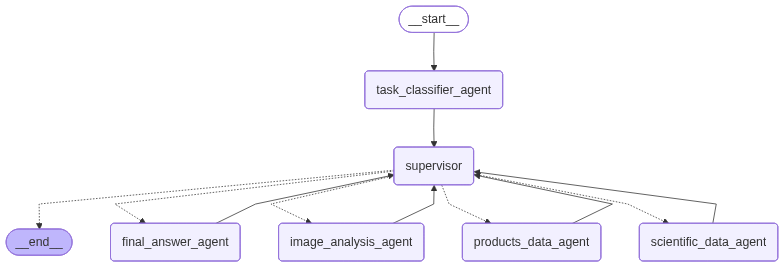

: 

In [ ]:
import sys
import os

# Create and compile the workflow graph
from langgraph.graph import StateGraph, END
from agents import supervisor_agent, image_analysis_agent, scientific_data_agent, products_data_agent, final_answer_agent,task_classifier_agent
from models import SupervisorState
from langchain_core.messages import AIMessage, HumanMessage

from typing import TypedDict, Annotated, List, Literal, Dict, Any

def router(state: SupervisorState) -> Literal["supervisor", "image_analysis_agent", "scientific_data_agent", "products_data_agent", "final_answer_agent", "__end__"]:
    """Routes to the next agent based on the state."""

    next_agent = state.get("next_agent", "supervisor")

    if next_agent == "end" or state.get("task_complete", False):
        return END

    if next_agent in [
        "supervisor",
        "image_analysis_agent",
        "scientific_data_agent",
        "products_data_agent",
        "final_answer_agent",
    ]:
        return next_agent

    return "supervisor"


def create_workflow_graph():
    # Create workflow
    workflow = StateGraph(SupervisorState)

    # Add nodes
    workflow.add_node("task_classifier_agent", task_classifier_agent)
    workflow.add_node("supervisor", supervisor_agent)
    workflow.add_node("image_analysis_agent", image_analysis_agent)
    workflow.add_node("scientific_data_agent", scientific_data_agent)
    workflow.add_node("products_data_agent", products_data_agent)
    workflow.add_node("final_answer_agent", final_answer_agent)

    # Set entry point
    workflow.set_entry_point("task_classifier_agent")

    workflow.add_edge("task_classifier_agent", "supervisor")

    # Add conditional edges only from the supervisor
    workflow.add_conditional_edges(
        "supervisor",
        router,
        {
            "image_analysis_agent": "image_analysis_agent",
            "scientific_data_agent": "scientific_data_agent",
            "products_data_agent": "products_data_agent",
            "final_answer_agent": "final_answer_agent",
            END: END,
        }
    )

    # Each agent returns control to the supervisor
    for node in [
        "image_analysis_agent",
        "scientific_data_agent",
        "products_data_agent",
        "final_answer_agent",
    ]:
        workflow.add_edge(node, "supervisor")

    # Compile the graph
    graph = workflow.compile()
    return graph

workflow_graph = create_workflow_graph()

workflow_graph






























